---
> 畳み込むの意味は、折りたたんで中に入れること、心の中に深く留めること、工学的には移動しながら共有部分の和を求めていくこと
>
> 畳み込み演算に意味ができることの本質は線形で時不変であること、受けた影響の総和が求まるということ
>
> RC回路に方形波を入力する時その出力を、RC回路のインパルス応答曲線と、方形波との積分を、方形波を移動させながら求めて応答を得るのが畳み込み積分
>
> 源画像データとフィルタ行列とのアダマール積を移動しながら求めるのが畳み込み層
>
> この授業も教師曲線と学生曲線の畳み込み値が大きくなるようにしたい
>
> それ以前に線形で時不変であることが難しいのだが
---

# 畳み込み層とプーリング層

## 畳み込み層(convolution layer)について

畳み込みニューラルネットワーク、Convolutional Neural Network (CNN)については既に説明済みである

特に画像に用いるが、画像など2次元データから特徴を効率よく集めることができる仕組みといえる

CNNについての本質的な理解は、画像フィルタリングの動作原理を理解していれば掴みやすいであろう
- 画像とオペレータのアダマール積により、エッジ抽出や線分抽出などの画像フィルタが記述できる
- オペレータを工夫すれば、他にも様々な特徴が抽出できることは画像処理の基本事項として著名である

なお、後で確認できるが、画像に対して全結合網で次元削減しながら学習させるのと、CNNを使うのでは明確にCNNの方が性能がよくなる



## 畳み込み層の動作

全結合層は、出力を求めるためにパラメータ行列${\bf W}$が全次元を備えており、かつその全ての要素（ベクトルであれば全次元の値）を用いる

先に示した通り、順伝播ではノードの結合は、行列の要素の積で表現されており、パラメータ行列${\bf W}$の$i, j$要素である$W_{ij}$と、入力データ${\bf x}$の全要素で結合を表現している、つまり、ある層の全ノードが、次の層の全ノードへの結合を有することを意味す\
これを全結合(fully-connected)と表現する

- 畳み込み層は全結合層とは異なり、パラメータと入力データの間の結合が局所的にしか存在しない

- 例えば、2次元畳み込み層では、パラメータはカーネル(もしくはフィルタ)と呼ばれる小さな画像パッチ(例えば6x6といった画像の一部分)を表す行列の集合とみなし、パッチごとに入力データの一部との間で演算が行われる

次の図を用いて、$3 \times 3$のサイズの小さな画像パッチに関する畳み込みカーネルを2つ持つ畳み込み層の計算過程を考える

<img src="http://class.west.sd.keio.ac.jp/dataai/text/convolution.gif" width="50%">

左の青ブロックは入力画像を表す\
入力は$5 \times 5$ の大きさを持つRGBの3チャネル画像であり、チャネル数分縦に並べている
- これに次に説明するパディング処理により7$\times$7に拡張されている
- $W0$、$W1$それぞれについて以下を計算する(アニメーションは$W1$のみ)
  - 後述するストライドは2である
  - 青のブロックと赤のブロックのアダマール積を各チャネル毎求めて、さらにその結果の全要素を足し集める
    - チャネル毎9要素、さらにチャネル3つ分、さらにバイアス値も全て足し合わせる
  - すると対象となるフィルタの3$\times$3の行列が完成する

### フィルタとしてのチャネル

CNNを利用する際、次の図のように複数のフィルタを同時に用いることが多い
- この図において情報の次元数であるチャネル数の移り変わりについてまとめる
- 画像の画素の位置(x,y)の2次元の情報のチャネルに加えてRGBの色情報チャネルを含む3チャネルあるが、同数の3枚のフィルタが必要となる
- フィルタと畳み込み演算を行ったRGB各チャネルのデータを合計して1チャネルのデータとする
- バイアスを与えて活性化関数による演算を施す
- 結果としてフィルタ数分のチャネルの生成データが得られる
  - 画像としてみることもできるが、画像と呼べるかどうかは微妙であるため生成データとここでは表現している

<img src="http://class.west.sd.keio.ac.jp/dataai/text/cnnch.png" width="60%">

畳み込み層の処理は、2次元だけでなく、1次元や3次元にも拡張でき、PyTorchはネイティブでconv1d, conv2d, conv3dを備える
- conv4dなどもGitHubなどで利用できる

オプションは次の通り

| | |
|:--|:--|
|in_channels (int)| 入力チャネル数、最初の層なら通常RGBで3 |
|out_channels (int) | 出力チャネル数でフィルタ数 |
|kernel_size (int or tuple) |各フィルタカーネルのサイズ|
|stride (int=1 or tuple, optional)|ストライド|
|padding (int=0 or tuple, optional)|パディング幅|
|padding_mode (string='zero', optional)|多次元テンソルに対するパディング層の考慮に関する内容で指定<br>することはないであろう<br>なおpadというパディング専用の柔軟な関数も準備されている|
|dilation (int=1 or tuple, optional)|計算したカーネルの値を並べる際のストライド|
|groups (int=1, optional)| 入力から出力へのカーネルの分割ブロック数で並列化の指定<br>一般にgroup convolutionとは異なる複数のカーネルを一つの入力に<br>適用することであるが、その文脈では定義されていない|
|bias (bool=1, optional)|True=1であれば、学習可能なバイアスを追加する|


### パディング

まず、パディング(padding)処理により、入力画像の周囲に値が0となる領域を付け足す\
ここでは、幅1の領域をパディングしている

- パディング処理は、行列演算上配列要素がデータの存在しない領域、具体的にはアクセスが許されていないメモリ部分へのアクセスを行わないように工夫している

- 中央2列ある赤ブロックは、それぞれの列が1つの畳み込みカーネルを表す
  - 1つの畳み込みカーネルは、入力画像、もしくは中間層では特徴マップ(feature map)呼ばれる一つ前の層の出力が持つのと同数のチャネルを持つ

- 3チャネル分の縦に並んだ3つの赤い$3 \times 3$ブロックで表されており、$b$はバイアス、$W$はオペレータを意味する

### CNNにおけるバイアス

最後に、これにカーネルごとに用意されるバイアスの値、例えば図では1つ目のカーネルのバイアスは$b0$であり1を足せば、このカーネルの入力の左上隅の領域に対する出力結果である0となる

右の緑色ブロックで示される畳込み層の出力値について、1つ目のブロックの左上のマスには、この結果である0が記載されている

- ここまで、個別のパラメータ値を用いた**重みを掛けてバイアスを足す** というシンプルな線形変換のみで構成されており、この変換はパラメータおよび入力について微分可能である

  - 実際、カーネルサイズが $1 \times 1$ のカーネルを用いた畳み込み演算は各入力次元に同一の重み行列を用いた線形変換を施すのと同じである

  - たとえば，入力幅$W$と高さ$H$の$W \times H$ で3チャンネルである場合、カーネルサイズが $1 \times 1$ の畳み込み層のカーネルは $1 \times 1 \times 3$ のテンソル、バイアスは1次元のスカラーとなる

- この$W \times H$ 個の全ての入力次元について、テンソルとスカラーによる線形変換を施すことになる

このように、畳み込み層はカーネルを様々に定義することで多様なデータ形式を扱うことができる
- データに合わせて、例えば温度センサの時系列データであれば1次元のカーネルを、動画やボクセルであれば3次元のカーネルを用いればよい

## プーリング層（pooling layer）

プーリングは主に特徴マップに対して行われる操作であり、特徴マップの空間方向の次元(spatial dimension、つまり入力画像における幅・高さに対応する次元)の大きさを削減し計算量を抑える目的や、物体の微小な平行移動によって出力が変化しないようにして画像認識処理におけるロバスト性向上をはかる目的に利用する

- プーリングにおける計算対象範囲や方法は畳み込みと類似しているが、対応する入力の部分領域に対する平均や最大値を求める演算が行われる
- 従って、畳み込みカーネルを用いるような計算は行わず、また、関連するパラメータも存在しない

部分領域ごとの平均値を計算する場合を平均値プーリング(average pooling)、最大値を計算する場合を最大値プーリング(max pooling)と呼ぶ

具体的には、次の図のような処理が行われる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/pooling.png" width="50%">

図の左側は、プーリング層を用いたダウンサンプリング処理を示している
- サイズが$224 \times 224$、$64$ チャネルの特徴マップに適用し、縦横両方について半分の大きさ($112 \times 112$のサイズで情報量は1/4)の特徴マップに変換している
- このとき、チャネル数(画像ではdepthとも呼ぶ)は$64$で維持されている

図の右側にその具体的な計算方法を示す
- $8 \times 8$の入力について、$2 \times 2$ 領域ごとに最大値で置き換えるという処理が示されている
- 例えば左上の$[1,1,5,6]$という要素について、その領域の最大値である6が選択されている
- これをストライド数2でずらしながら求めれば、右の$2 \times 2$の行列が得られる

以上のように、ある領域の最大や平均といった値を取得してさらにデータサイズを縮約する手法である

画像では一般的にmax poolingが用いられ、最も特徴的な値のみを次に伝えるという効果が得られる
- 平均プーリングは2016年に提案された画像物体認識DNNであるLeNetで利用されたが、普通利用しない
- ややこしいが、ResNetでは全平均を計算するglobal average poolingが用いられる

pooling層なしにCNNを重ねてもよいのではないか？という考えもあると思うが、計算コストを削減する意味でCNNとpoolingを交互に重ねるような構成が多くみられる
- どのみち特徴を抽出するという明確な目的においては、特徴がある、つまり値の大きいところを選び出せばよいと考えられる
- poolingの方が演算コストが小さいことから、抽出するという処理であればpoolingを用いることで学習に必要な計算コストを削減できる





## ストライドについて

各カーネルの各チャネルは、対応する入力のチャネルに対してスライドしながら計算を行う

- このスライド幅をストライド(stride)と呼ぶ
図では2マス飛びに入力画像上を$3 \times 3$の枠が移動しているため、ストライドは2である

- 対象となる$3 \times 3 = 9$個の要素を$W1$とそれぞれ掛け合わせた結果を全て足し(オペレータ演算)、さらにバイアス$b0$を足せば、$o[:,:,0]$の対応する左上の値$o[0,0,0]$が得られる
  - $W0$と$W1$に対応する演算があるため、出力の緑ブロックに2つの行列が存在する
  - これらを**フィルタ**と呼ぶ

  - なお、ここでの掛け算は、アダマール積であり、結果として得られる$3 \times 3$の値を全て足し集めれば、このカーネルの1つ目のチャンネルの1つ目の計算結果が得られる。ここでは、-2となる。

このような演算がなぜ画像と親和性が高いかは、マルチメディアデザインの授業で学んだ画像処理の基本であるオペレータの概念が含まれていることから感覚的に理解できるであろう

- オペレータは様々な特徴量、例えば、直線や三角、四角などの図形に特徴的に反応することができるため、これを抽出しているといえる

- 2チャンネル目および3チャネル目も同様に計算すると、それぞれ0および1となり、最後に全てのチャネルの結果を足し合わせると結果は-1となる

一般に畳み込み層ではストライドは1となり画像サイズに大きな差が出ない

プーリングではプーリング用のフィルタサイズに合わせてストライドが設定される
- つまり、プーリングの各演算範囲が重ならないようにずらす
- 最大値が欲しいのであるから、重なってはいけない
  - 重なると同じ最大値が複数回結果に表れてしまい、特徴が重複・強調される


## 出力データのサイズについて

次のように変数を定める
- 入力画像高さ,幅: $I_h$, $I_w$
- フィルタ高さ,幅: $F_h$, $F_w$
- パディング幅: $D$
- ストライド幅: $S$

すると、出力画像の高さ$O_h$と幅$O_w$は次のように表される
$$
O_h = \frac{I_h-F_h+2D}{S}+1\\
O_w = \frac{I_w-F_w+2D}{S}+1
$$

例:畳み込み層
- 入力画像: 32$\times$32、RGB 3チャネル
- フィルタ: 5$\times$5, フィルタ数6
- パディング: なし
- ストライド: 1

このとき、出力データは、
$(32-5+2\times 0)/1+1=28$となる

すなわち、6チャネルの28$\times$28のデータとなる

例:プーリング層
上記データを入力とする
- 入力画像: 28$\times$28、6チャネル
- 領域サイズ: 2$\times$2

このとき、出力データは、
$20/2=14$となる

すなわち、6チャネルの14$\times$14のデータが得られる

全体をまとめると次の通りとなる

| | | | |
|:-:|:-:|:-:|:-:|
| |**CONV**|**POOL**|**FC**|
|図|<img src="http://class.west.sd.keio.ac.jp/dataai/text/table-conv.png" width="150">|<img src="http://class.west.sd.keio.ac.jp/dataai/text/table-pool.png" width="150">|<img src="http://class.west.sd.keio.ac.jp/dataai/text/table-fc.png" width="150">|
|入力サイズ|$I \times I \times C$|$I \times I \times C$|$N_{\text{in}}$|
|出力サイズ|$O \times O \times K$|$O \times O \times C$|$N_{\text{out}}$|
|パラメータの数|$(F \times F \times C + 1) \cdot K$|$0$|$(N_{\text{in}} + 1 ) \times N_{\text{out}}$|
|備考|•フィルタ毎にバイアスがある<br>•一般に$S<F$<br>•一般に$K=2C$|•プール操作はチャネル毎<br>•一般に$S+F$|•ニューロン毎にバイアス1つ<br>•ニューロン数に構造的制約なし|


(裏技)

基本的には、上記の式は暗記する必要はない
- なぜなら、適当な値を入れた場合でも、実行時エラーとなり、その際「あるべき値」を通知してくれる
- その「あるべき値」にすれば、なんら問題なく正しい値を設定できる

## 畳み込み層でよく利用される活性化関数

ReLUが一般的に用いられるが、次のような活性化関数が利用される
- 悩むぐらいならReLUで十分

| | | |
|:-:|:-:|:-:|
|ReLU|Leaky ReLU|ELU|
|$g(z)=\max(0,z)$|$g(z)=\max(\epsilon z,z)$<br>ただし$\epsilon\ll1$|$g(z)=\max(\alpha(e^z-1),z)$<br>ただし$\alpha\ll1$|
|<img src="http://class.west.sd.keio.ac.jp/dataai/text/figrelu.png" width="150">|<img src="http://class.west.sd.keio.ac.jp/dataai/text/figleaky-relu.png" width="150">|<img src="http://class.west.sd.keio.ac.jp/dataai/text/figelu.png" width="150">|
|•生物学的に解釈可能な構成かつ非線形|•ReLUの負値不感問題に対処|•どこでも微分可能|


# データ拡張(data augmentation)による汎化性能向上

データ拡張とは、汎化性能を向上するためにデータを水増しすることである

- 例えば、訓練データのサンプル数が少ない場合などにおいては、過学習が進みやすく汎化性を失う

- その単純な対策の一つが、**データを増やす**ということ、これがデータ拡張の意味である

## 実際のデータ拡張

画像データでは次のような方針がとられる
- 画像を様々な方向に回転させる
- 画像を拡大・縮小する
- 画像の平行移動
- 画像の上下・左右の反転
- 画像の一部を削除する(隠す)

# ドロップアウト(dropout)

具体的に何をするかは説明済みであるので、その用い方のテクニックについて述べる

- 出力層以外の通常ノードを一定確率でランダムに消去する
- 実装が容易で過学習を抑制でき、またその効果が大きい
- バッチごとに消去する結合を変更する

また、

- ドロップアウト率$p$に基づきノード単位でドロップアウトするかどうかを決定する

- CNNでは用いてはいけない

  - 重要な特徴を捕まえられなくなる
  - そもそもCNNはものすごい勢いで情報圧縮・次元圧縮している

- 解釈としては、ランダムフォレストで利用したアンサンブル学習と同じ効果が期待できる

  - Dropoutによりスリム化されたネットワークを組み合わせると解釈できる

Dropoutしても安定して学習できるようになってしまった、そういう技術ができてしまったということ

近年では、画像処理応用が旺盛で、CNNではdropboutを用いないため、あまり利用されていない

- Dropoutさせた方が学習で最適解に至る速度は低下する

- ならば、ちゃんと監視して過学習に至る前に学習をやめればよいという意見もある

# バッチノーマライゼーション(Batch Normalization)

Batch Normalization(以下BN)はシンプルでありながら、

> 特にGAN等安定化しにくいネットワークが利用可能になったのは、Batch NormalizationとAdamによる功績が大きく、なければノイズしか出てこない

といわれており、また、今後VAEについても学ぶが、

> VAEでも、うまくいかなかった事例が、Batch Normalizationを入れるといきなり学習が成功した

という事例も報告されている

BNはもともと、勾配消失・爆発を防ぐための手法として提案され、そのための対策として、
- 活性化関数をReLUなどに変更
- ネットワークの重みの初期値を事前学習しておく
- 学習係数を下げる(遅くなる)
- ネットワークの自由度を下げる
  - Dropoutもこの手法の一つ

といった対応が取られてきたが、これに対する新たな対応手法である

### バッチノーマライゼーションの処理内容

BNとは、各ユニットの出力をminibatchごとにnormalizeした新たな値で置き直すことで、内部の変数の分布(内部共変量シフト)が大きく変わるのを防ぎ、学習を進め、過学習を抑える手法である
- 要するに、ネットワークの途中で伝播している値を無理やり正規化する手法
- 特に**白色化(whitening)**と呼ばれる手法では、平均0、標準偏差1に途中変換すればニューラルネットワークの収束が速くなることが知られている
- ネットワークの層の中に$\boldsymbol{H}$という行列を配置する
  - 各行がminibatchの1つのデータ、各列がそれぞれのactivationとなるような値をとる行列
  - 例えばbatch sizeが128, hidden unitの数を256とすると、  $\boldsymbol{H}$ は128×256の行列

正規化のため、次のように$\boldsymbol{H}'$ と置き直すのがbatch normalizationの仕組み

$$
\boldsymbol{H}' = \frac{\boldsymbol{H}-\boldsymbol{\mu}}{\boldsymbol{\sigma}},
$$

- $\boldsymbol{\mu}$と$\boldsymbol{\sigma}$ は、その層での各ユニットの平均および標準偏差のベクトル

訓練時の$\boldsymbol{\mu}$と$\boldsymbol{\sigma}$ は次の式を用いて算出する

$$
\boldsymbol{\mu} = \frac{1}{m} \sum_i \boldsymbol{H}_{i,:}, \\
\boldsymbol{\sigma} = \sqrt{\delta + \frac{1}{m} \sum_{i}(\boldsymbol{H}-\boldsymbol{\mu})^2_i}
$$

- $\delta$ は標準偏差が0にならないようにする十分小さな値

推定時は、minibatchはないため、訓練時に利用した値の移動平均などを$\boldsymbol{\mu}$と$\boldsymbol{\sigma}$に適用する

### バッチノーマライゼーションの種類

処理方法は同一であるが、1度に正規化する範囲の違いから次のような種類がある
- バッチノーマライゼーション：ミニバッチの同一箇所(BachNormalization演算が割り当てられている同じ層)の間で正規化する
- レイヤーノーマライゼーション：異なるレイヤ(チャネル)全体で正規化する手法で、RNNやTransformerで用いられる
- インスタンスノーマライゼーション：1つのレイヤチャネルだけで正規化する手法で、StyleGANなどのGANで用いられる
- グループノーマライゼーション：異なるいくつかのレイヤ(チャネル)で正規化する手法で、画像認識で用いられることがある

<img src="http://class.west.sd.keio.ac.jp/dataai/text/normfig.png" width="80%">

(N, C, HW) の 3 次元からなる多次元配列について、例えばCNNではバッチサイズ N, チャンネル数 C, 画像の縦幅 H, 画像の横幅 W に相当する

### なぜバッチノーマライゼーションが有効なのか

- 実はかなり厄介な問い
- まず指摘されるのが、内部共変量シフト(= ICS, Internal Covariance Shift)の解消(とされていた)
  - ニューラルネットの層を過ぎる毎にその層のアウトプットの分布が変わる(これをICSと呼ぶ)が、このようにニューラルネットの中を通るデータの分布が頻繁に変化すると学習が困難になるであろう(と考えられていたが、実際は違う)
  - であれば、BNはこのICSを正規化により解決し、精度向上に寄与する(といわれていた)

しかしながら、実際に調べるとBNではICSは解決されないため、この主張は誤っているであろうというのが現在の見解
- ですが、この考え方には大きなヒントがある
- ある重みを更新する際に、本来その前の各層の重みがどのように更新されるのかを考慮する必要がある
- BNを用いることで、その前の全体の層の関係を表現した値を利用できる
というのが、現在の解釈

### BN利用のメリット
- 学習係数を大きくすることができる
  - 学習係数を増加させるとパラメタの大きさが飛躍的に増え、勾配消失や勾配爆発につながるため大きくできなかった
  - 途中で正規化すればパラメタが飛躍的に大きくなることを防ぐことができる

- 正則化効果がある
  - L2正則化の必要性がほぼなくなる
  - Dropoutの必要性がほぼなくなる
    - 近年ではDropoutがあまり利用されていないが、これはBNの影響によるところが大きい
    - Dropoutは学習速度が低下するが、BNは逆に向上するので利用価値が薄れてしまった
- ネットワークの重みの初期値の影響を受けにくい

- より深いネットワークでも学習可能となる  
バッチノーマライゼーション導入以前は、深いネットワークの学習が困難であったが、バッチノーマライゼーション導入によりより深いネットワークでも学習できる様になった

- バッチノーマライゼーションは過学習抑制効果が存在する

### BNの使い所

深めのネットワークを作ったときに、数カ所挟むと良い

フィルタや重みの演算とバイアスの演算の後、活性化関数の前に挟むと良い
- 効果的に挟むと学習が速く進み、最終的に収束するLossの値も低くなる
- デメリットとして、パラメータが多くなりメモリや演算量が多くなる

性能で悩んだら、まずはBNの利用を検討するべきである

PyTorchでは、画像の場合`BatchNorm2d`が提供されている

# MNISTのCNNによる分類

今まで何度も取り扱ってきたMNISTを改めてCNNを用いて評価する

プログラムも理解が進んでいると思うので、より行儀のよいスタイルにする

GPU対応の確認を行う
- PyTorchはGPUモードを明示的に指定する

In [ ]:
cuda = "cuda:0"
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
# ハイパーパラメータ
num_epochs = 10
batch_size = 128
learning_rate = 0.001
# GPU存在のチェック
device = torch.device(cuda if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

MNISTを読み込むDataSetとDataLoaderを作成する

In [ ]:
# MNISTデータセット
train_dataset = dsets.MNIST(root='mydata',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = dsets.MNIST(root='mydata',
                           train=False,
                           transform=transforms.ToTensor())
# DatasetLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.02MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.64MB/s]


## モデルの作成

- CNNはブロック単位で処理した方がよいのでブロック（Conv+BN+ReLU+Pooling）ごとにまとめて Sequential を使うとわかりやすくなる
- Conv2d や BatchNorm2d は出力のユニットサイズをきちんと指定する
- サイズを自分で計算するのが面倒ならば、モデルの途中結果サイズを`print(out.size())`や`print(out.shape)`として出力して確認するとよい
  - ここではそのようにして調べた
- ネットワークの指定は画像1枚に対して記述しているように見えるが、実際にはバッチ数分並列して動作するため、推定結果もバッチ数分出力されることに注意する
  - つまり、画像一枚に対するノード数が、さらにバッチ数分一挙に出力される

このサイズの求め方は面倒なので、printしてみて納得したら、`out.size(0)`のように指定すると若干？お手軽である
- この場合`print(out.shape)`では`torch.Size([128, 32, 7, 7])`と表示される
- 先頭の100はバッチサイズで、これが`out.size(0)`である
  - ネットワークは内部では128個並列で作成され、推定結果も128個並列して出てくる
  - それが全て配列になって保存される、一つの画像当たり$32\times 7\times 7$の数のノードの出力が得られる
- 最終的には128個の並列した推定結果が欲しいので、`torch.Size([128,1568])`となってほしい
  - そこで、ノードの個数がわかるのならば、バッチサイズを未確定として`view(-1,1568)`としてもよいし、バッチサイズがわかるのであればノード数を未確定として`view(128,-1)`としてもよい
  - バッチサイズは、`torch.Size([128, 32, 7, 7])`なので、`out.size(0)`で得ることができ、`view(out.size(0), -1)`が成立する

後半のCIFAR-10では畳み込み層の出力サイズを求める計算式を示して計算してサイズを得るため、こちらのノードサイズを未確定とする例と違いバッチサイズを未確定としている
- どちらも同じであるが、`out.size(0)`を用いる方がお手軽である
- とはいえ、結局ネットワークの定義で、`nn.Linear(7 * 7 * 32, 10)`とする必要があるため、ノード数の情報は必要となることから、お手軽さは限定的

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=5, padding=2),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(2))
    self.layer2 = nn.Sequential(
      nn.Conv2d(16, 32, kernel_size=5, padding=2),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(2))
    self.fc = nn.Linear(7 * 7 * 32, 10)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1) # あまりよくない書き方
    out = self.fc(out)
    return out
model = CNN().to(device)
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [ ]:
# テスト
images, labels = next(iter(train_loader))
images.size()

torch.Size([128, 1, 28, 28])

In [ ]:
labels.size()

torch.Size([128])

今回のモデルのように、Batch NormalizationやDropoutなど学習時と推論時で挙動が変わるレイヤを使う場合はモデルのモードに注意して、きちんと切り替えること
- model.train() で訓練モード
- model.eval() で評価モード
  - 切り替えなくてもエラーにはならないがそもそも結果に影響するなどの弊害が発生する
- torch.no_grad()も忘れずに
  - こちらは忘れてもよいが、特にGPUでは処理速度やメモリ効率の影響が大きくなる
また、GPUモードで動かすときはテンソルを下のように to(device) でGPUに送る必要がある

モデルオブジェクトを生成する

GPUモードで動かすには

- モデルを to(device) でGPUに転送する
- テンソルデータも to(device) でGPUに転送する

の2つだけ実装すればよい

In [ ]:
images = images.to(device)
labels = labels.to(device)

In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 訓練

今後テンプレ的に使えるよう、ここでは精度も計算するが、精度を求めるのは若干工夫がいる
- **一気にまとめて調べ上げる方法**で普通によく見る記述
- まずモデルの出力が全検証のそれぞれのテンソルを持つ
- そこで、各テンソルの最大値を集めれば、それが予測ラベル
  - `predicted = outputs.max(1, keepdim=True)[1]`
- view_asはtensorとtensorを比較する時などで形を揃えたい時に便利な関数で、型をsize()で調べてviewで変換するなどとしなくても変換できる
  - viewは、直接、型を指定するが、view_asは他のテンソルの型に倣って変換してくれる
    - `labels.view_as(predicted)`でlabelテンソルをpredictedテンソルの形に変換
    - eqで複数を同時に比較、それぞれでTrueかFalseを得る
    - そのうちのTrueの数をsumで数える
    - Trueは1で、Falseは0扱いなので、sumするとTrueを数えるのと同じ
    - item()でPythonの普通の数字として取り出す\
    これを忘れると、`correct/total`の計算がtensorの割り算となりうまくいかない
    - これをcorrectに加える

- 別の方法として、**一つの結果であれば**`correct += (outputs.argmax(1) == labels).sum().item()`とすることもできる
  - 中身は同じだがargmaxで最大値となる**場所**を取得してそれがラベルと一致すれば正解、これを合計して、pythonの数字として取り出している
  - ただし**一つの結果だけ**であり、**全結果まとめて計算しているわけではない**ことに注意する

In [ ]:
def train(train_loader):
  model.train()
  running_loss = 0
  for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
  train_loss = running_loss / len(train_loader)
  return train_loss

def valid(test_loader):
  model.eval()
  running_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      predicted = outputs.max(1, keepdim=True)[1]
      correct += predicted.eq(labels.view_as(predicted)).sum().item() # ここで精度を計算
      total += labels.size(0)
  val_loss = running_loss / len(test_loader)
  val_acc = correct / total
  return val_loss, val_acc

loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
  loss = train(train_loader)
  val_loss, val_acc = valid(test_loader)
  print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss, val_loss, val_acc))
  # logging
  loss_list.append(loss)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)

# save the trained model
np.save('loss_list.npy', np.array(loss_list))
np.save('val_loss_list.npy', np.array(val_loss_list))
np.save('val_acc_list.npy', np.array(val_acc_list))
torch.save(model.state_dict(), 'cnn.pkl')

epoch 0, loss: 0.1500 val_loss: 0.0537 val_acc: 0.9830
epoch 1, loss: 0.0496 val_loss: 0.0455 val_acc: 0.9861
epoch 2, loss: 0.0378 val_loss: 0.0360 val_acc: 0.9877
epoch 3, loss: 0.0294 val_loss: 0.0275 val_acc: 0.9904
epoch 4, loss: 0.0246 val_loss: 0.0346 val_acc: 0.9884
epoch 5, loss: 0.0216 val_loss: 0.0384 val_acc: 0.9881
epoch 6, loss: 0.0184 val_loss: 0.0328 val_acc: 0.9895
epoch 7, loss: 0.0148 val_loss: 0.0314 val_acc: 0.9906
epoch 8, loss: 0.0120 val_loss: 0.0352 val_acc: 0.9889
epoch 9, loss: 0.0107 val_loss: 0.0333 val_acc: 0.9909


## 結果表示

前回、多層パーセプトロンでの精度が85%くらいだったので99%程度出るCNNはかなり性能がよいことがわかる

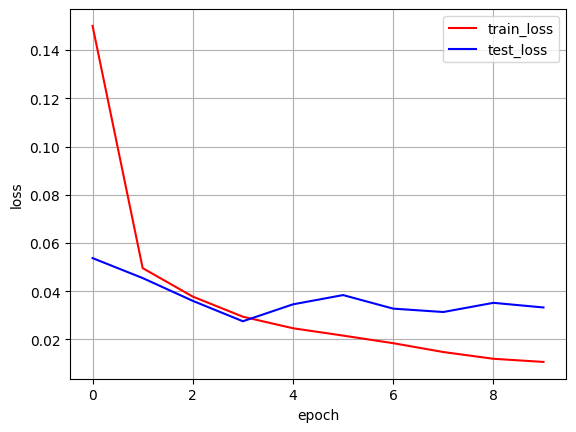

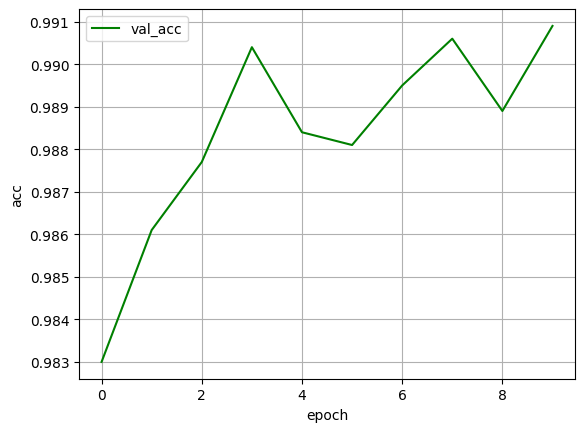

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# plot learning curve
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='test_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()

# 課題1(BNの効果)

## 問題(1)

バッチノーマライゼーションとミニバッチの関係について簡単に説明しなさい

また、ミニバッチサイズがバッチノーマライゼーションの結果にどの様に影響を及ぼすであろうか、簡単に述べなさい

## 問題(2)
上記例ではバッチノーマライゼーションを用いたモデルが定義されている

そこで、バッチノーマライゼーションを利用しないモデルを構築し、精度や学習速度などを比較しなさい



# CIFAR-10のCNNによる分類


次は同じことをCIFAR-10で行う

初めに必要なライブラリをimportしておく

必要な時にそれぞれ読み込むのが本来は正しいのかもしれないが、テンプレート化した方が使い勝手が良い

なお、`from rotch.utils.data import DataLoader`としていたためDataLoaderで読み込めるが、ここでは、敢えてクラスを辿ってDataLoaderを指定する

同様に、`from torchvision.datasets import CIFAR10`とすると`train_set = CIFER10...`とできる

どちらでも好みでよい

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
device = torch.device(cuda if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


ハイパーパラメータを宣言

In [ ]:
num_epochs = 20
batch_size = 128 # GPUを使うなら大きくてもよい
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

## CIFAR10データの確認

本来は不要だが、CIFAR10データの中身を確認してみる

- CIFAR-10はラベル付きの6万枚のカラー画像により構成されるデータセットで、画像サイズは$32 \times 32$
- ラベルも少なく、10種類のみ

普通にmathplotlibの機能を利用すると、次のような表示となる

100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


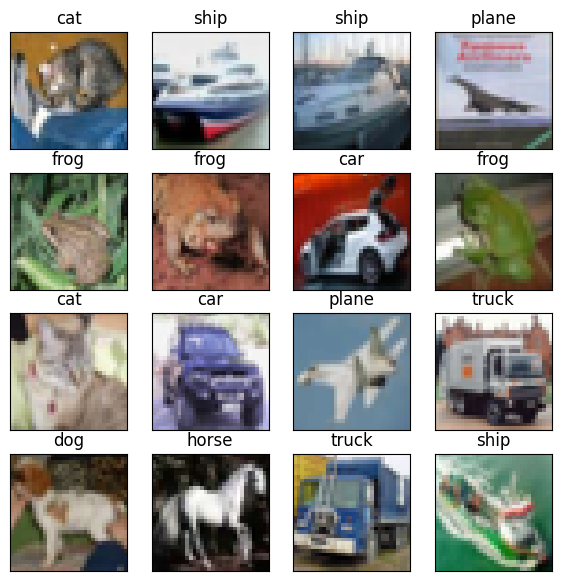

In [ ]:
cifar10 = torchvision.datasets.CIFAR10(root="mydata",
                       train=False,download=True,
                       transform=transforms.ToTensor())
plt.figure(figsize=(7,7))  # 画像の表示サイズ
chkdata = iter(torch.utils.data.DataLoader(cifar10, batch_size=4*4, shuffle=False))
chkimages, chklabels = next(chkdata)  # イテレータから最初のバッチを取り出す
for i in range(4*4):
  plt.subplot(4,4,i+1)
  plt.imshow(np.transpose(chkimages[i], (1, 2, 0)))  # チャンネルを一番後ろへ
  label = classes[chklabels[i]]
  plt.title(label)
  plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

## データ拡張

### データの回転・反転・拡大縮小

CIFAR-10の画像情報をランダムに回転、左右反転および拡大縮小する

transforms.Composeにより配列で処理順序を指定する、つまり**順番が重要となる**

- 例えば、`Normalize`と`RandomAffine`の順番を逆にするとエラーになる
  - `RandomAffine()`はtorch型ではなく、PIL.Imagesを返すため、`ToTensor`よりも,前に`RandomAffine`を施す必要がある

  - これらの変換は**データを取得する度に実行される**ので、同じデータを取り出しても異なる回転、反転、拡大縮小の画像が得られることに注意する
  - appendして増やそうなどと考えなくともよい

### PyTorchが備えるデータ拡張手法

PyTorchには、データ拡張用に次の手法が準備されている
- RandomHorizontalFlip:  画像を確率pで左右反転する
- RandomAffine: 画像をランダムに回転/拡大縮小する
- RandomErasing: 画像をランダムな一部分にノイズを付加する
- RandomPerspective: 画像を確率pでランダムに透視変換、すなわち視角を変える

などがある、他にも便利な、
- Resize: 画像のリサイズ
- CenterCrop: 画像の中心に移動する

などの機能も備えている

### データの標準化

データ拡張とは関係ないが、CIFAR-10の画素情報をオリジナルの [0, 1] から[-1, 1] になるように標準化する

- `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`について、一つ目の引数のタプルはRGBの各チャンネルの平均を表し，二つ目の引数のタプルは標準偏差を表す
  - つまり0から1のデータの平均値はおそらく0.5に近い値であると思われるので、平均を$mean=0.5$として、これを正規化後0にする
  - $z=\frac{x-mean}{std}$として求められ、$std=0.5$とすれば、丁度取りうる値の範囲が1から2倍の2となる
   - これを全チャネルに対して処理する

- 画像を表示させてから標準化させてもよいが、途中結果を表示する際に変な絵が出てきてびっくりということになりかねない

  - ここでは、あえて先に標準化し、標準化した画像を表示させるようにしている

### DataLoader

num_workers を指定するとファイルの読み込みが並列化され、例えばCPUのコアが複数ある場合は一気に速くなる

`batch_size`は、`train_loader`では`batch_size`を指定しているが、`test_loader`では`len(test_set)`として全て食べさせている

In [ ]:
train_transform = transforms.Compose([
  transforms.RandomAffine([0,30], scale=(0.8, 1.2)), # 回転および拡大縮小
  transforms.RandomHorizontalFlip(p=0.5), # 左右反転
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [0, 1] => [-1, 1]
])
test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [0, 1] => [-1, 1]
])
train_set = torchvision.datasets.CIFAR10(root='mydata', train=True,
                          download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                          shuffle=True, num_workers=4)
test_set = torchvision.datasets.CIFAR10(root='mydata', train=False,
                          download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set),
                          shuffle=False, num_workers=4)
print("訓練データの数:", len(train_set))
print("検証データの数", len(test_set))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


訓練データの数: 50000
検証データの数 10000


torchvisionには、次のように複数の絵を纏めて一つの絵にする機能がある

(np.float64(-0.5), np.float64(132.5), np.float64(132.5), np.float64(-0.5))

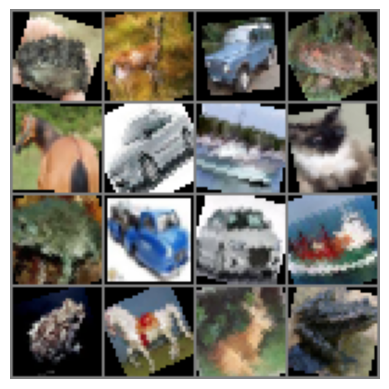

In [ ]:
def imshow(img):
  # unnormalize [-1, 1] => [0, 1]
  img = img / 2 + 0.5
  img = img.numpy()
  # [c, h, w] => [h, w, c]
  plt.imshow(np.transpose(img, (1, 2, 0)))
images, labels = next(iter(train_loader))
images, labels = images[:16], labels[:16]
imshow(torchvision.utils.make_grid(images, nrow=4, padding=1))
plt.axis('off')

PyTorchのチュートリアルに従い、ドロップアウト層を追加して別途CNNの簡単なモデルを定義する

レイヤの内容をよく確認すること
- 2つめの畳み込み層もプーリング層を伴っていることを確認する
  - forwardでそのように定義されている
- 次の全結合層はそれなりにノード数を大きくとっている
  - ドロップアウト層では、なんと50%ものノードの計算をスキップする
  - この全結合層の数を増やすのも面白いであろう
    - 各自試してみると良い
- 1つめの畳み込み層(conv1)の出力サイズ
  - 画像サイズは32$\times$32、フィルタサイズが5、パディングが0、ストライドが1なので、32-5+1=28
    - フィルタサイズはカーネルサイズとも呼ばれる
- 続くプーリングの出力サイズ
  - 2$\times$2なので、画像サイズは28$\div$2=14
- 続く畳み込み層(conv2)の出力サイズ
  - データサイズ14、フィルタサイズ5なので14-5+1=10
- 続く1次元化(view)では、フィルタ数16で各フィルタのサイズが10であるため、$16\times 5\times 5$の要素となる
- MNISTの例の通り、結局ミニバッチ数がわかっているので、`x.view(-1, 16 * 5 * 5)`という記述は、`x.view(x.size(0), -1)`でもよいが、いずれにせよノード数の情報は必要でそれほど得はしない

シンプルな画像認識について一番最初にデモを示したが、それでも23層、その何倍も層数の多いモデルも普通に存在する
- もうこうなると、どういうトポロジがよいのか確認するのも大変
- 経験がものをいう困った世界
  - AIなんて経験なんだよという矛盾

In [ ]:
class DNN(nn.Module):
  def __init__(self):
    super(DNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, kernel_size=5) # 畳み込み層(入力ch,フィルタ,そのサイズ)
    self.pool = nn.MaxPool2d(2, 2) # プーリング層(領域サイズ,ストライド)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5) # 2つめの畳み込み層
    self.fc1 = nn.Linear(16 * 5 * 5, 256) # 全結合層
    self.dropout = nn.Dropout(p=0.5) # ドロップアウト(ドロップアウト率)
    self.fc2 = nn.Linear(256, 10)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

ReLUは nn.ReLU() で層として定義する場合もあるが、パラメータがないので F.relu() のように関数として使うこともできる

モデルを確認する

In [ ]:
model = DNN().to(device)
model

DNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

## 学習

モデルを訓練する

- DataLoaderを用いてミニバッチ毎に訓練と評価を行う
- 評価時にミニバッチは使わずテストデータ全体を使って一度に誤差を計算する

同様に精度も求めており、さらにモデルと結果の保存も行う
- **訓練に5分程度必要となるので気長に待つこと**
- 訓練の待ち時間を勉強時間に含めると簡単に文科省の規定時間は満たせるであろう

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def train(train_loader):
  model.train()
  running_loss = 0
  for i, (images, labels) in enumerate(train_loader): # 一応回数も使えるように
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
  train_loss = running_loss / len(train_loader)
  return train_loss

def valid(test_loader):
  model.eval() # 今回はDropoutを利用しているので必須
  running_loss = 0
  correct = 0
  total = 0
  with torch.no_grad(): # メモリの効率利用、optimizer.zero_grad()を呼び出す必要がなくなる
    for i, (images, labels) in enumerate(test_loader):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels) # ロスの計算
      running_loss += loss.item()
      predicted = outputs.max(1, keepdim=True)[1] # 精度の計算
      correct += predicted.eq(labels.view_as(predicted)).sum().item() # 先の例で説明済み
      total += labels.size(0)
  val_loss = running_loss / len(test_loader)
  val_acc = correct / total
  return val_loss, val_acc

loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
  loss = train(train_loader)
  val_loss, val_acc = valid(test_loader)
  print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
        % (epoch, loss, val_loss, val_acc))
  # logging
  loss_list.append(loss)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)
print('訓練終了')
# 結果の保存とモデルの保存
np.save('loss_list.npy', np.array(loss_list))
np.save('val_loss_list.npy', np.array(val_loss_list))
np.save('val_acc_list.npy', np.array(val_acc_list))
torch.save(model.state_dict(), 'cnn.pkl')

epoch 0, loss: 1.8371 val_loss: 1.5551 val_acc: 0.4369
epoch 1, loss: 1.5887 val_loss: 1.4495 val_acc: 0.4845
epoch 2, loss: 1.5071 val_loss: 1.3640 val_acc: 0.5079
epoch 3, loss: 1.4573 val_loss: 1.2994 val_acc: 0.5332
epoch 4, loss: 1.4166 val_loss: 1.2904 val_acc: 0.5423
epoch 5, loss: 1.3920 val_loss: 1.2480 val_acc: 0.5574
epoch 6, loss: 1.3699 val_loss: 1.2455 val_acc: 0.5578
epoch 7, loss: 1.3586 val_loss: 1.2001 val_acc: 0.5772
epoch 8, loss: 1.3386 val_loss: 1.1913 val_acc: 0.5746
epoch 9, loss: 1.3254 val_loss: 1.1675 val_acc: 0.5847
epoch 10, loss: 1.3164 val_loss: 1.1851 val_acc: 0.5793
epoch 11, loss: 1.3106 val_loss: 1.1438 val_acc: 0.5965
epoch 12, loss: 1.2976 val_loss: 1.1498 val_acc: 0.5928
epoch 13, loss: 1.2868 val_loss: 1.1291 val_acc: 0.6043
epoch 14, loss: 1.2807 val_loss: 1.1434 val_acc: 0.5989
epoch 15, loss: 1.2702 val_loss: 1.1091 val_acc: 0.6125
epoch 16, loss: 1.2635 val_loss: 1.1059 val_acc: 0.6114
epoch 17, loss: 1.2547 val_loss: 1.0896 val_acc: 0.6185
ep

## 結果表示

アルゴリズム自体は、MNISTと全く同じである

今回もtestデータの方がロスが小さいが、これは前回説明した通り、ミニバッチを用いているため、そのtrainの平均としてのロスと、エポックでの学習が終了した状態でのtestのロスを比較しているためである

また、データ拡張を用いた際も、testデータの方がロスが小さくなる傾向にある

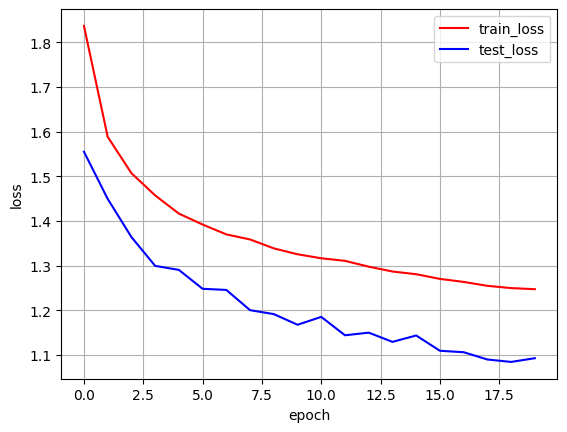

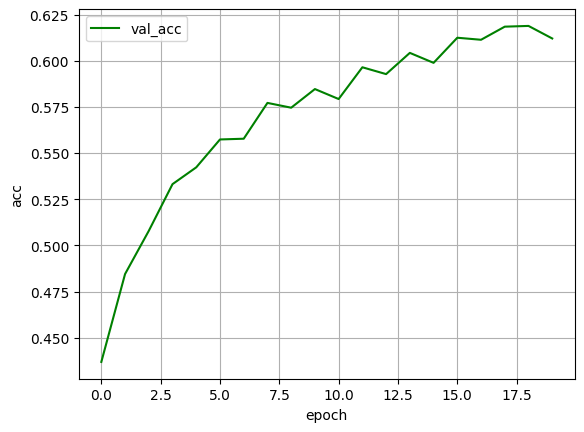

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# plot learning curve
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='test_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()

## 訓練済みモデルを用いた予測

画像を入力しモデルが機能していることを確認する

- 簡単なモデルであるため、精度は期待しないこと
- `shffle=True`としているため、このセルを実行する度にランダムに画像が選ばれ、評価される

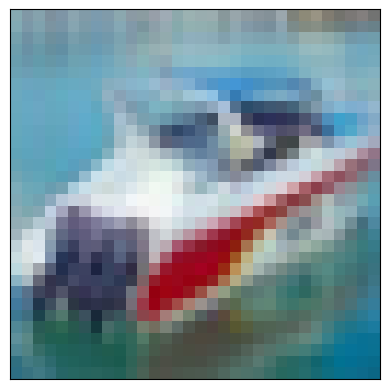

正解: ship 予測結果: ship


In [ ]:
dataiter = iter(torch.utils.data.DataLoader(cifar10, shuffle=True))
images, labels = next(dataiter)  # サンプルを1つだけ取り出す

plt.imshow(np.transpose(images[0], (1, 2, 0)))  # チャンネルを一番後ろに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

model.eval()  # 評価モード
imagee, labele = images.cuda(), labels.cuda()  # GPU対応
with torch.no_grad():
  labely = model(imagee)
print("正解:", classes[labels[0]],
      "予測結果:", classes[labely.argmax().item()])

# 課題2(BNとdropout)

上記モデルの中のdropoutを適切にバッチノーマライゼーションを用いて層をいれかえなさい

また、両者について精度や学習速度を比較しなさい

# 課題3(CNN)

**問題(1) CIFAR-10のコードを改良して精度を向上させよう**

レポート条件
- 上記の例の結果を添付する
- 改良し、上記よりも少ないエポック数で、上記よりも良い結果を得るモデルを作成して添付する
- 改良は、既習済みの内容であればどこを改良してもよい
  - データは指定したデータ以外使わないこと
  - ヒントはMNISTをちゃんと見るとすぐにわかる(じゃぁ、BNを使えと素直に言えばよいじゃん！ということになるが、皆さんの自由な発想は奪わないようにしたい)
- 評価部分などは一切触らないこと

**問題(2) CIFAR-10のコードについてデータ拡張を追加しよう**

レポート条件
- 領域のランダム消去(tansforms.RandomErasing)を**追加で**用いて評価しよう
  - 消去確率は0.5とすること
  - 正しく画像が一部消去されていることも確認すること
- 問題1とは独立です
  - なので、結果がよくなることは期待していません
- その他の部分は修正せずに提出すること

以下、PyTorchのページにあるマニュアルの簡単な翻訳です
- 課題は利用すればよいので、オプションにこだわる必要はありません

---
```torchvision.transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)```

画像内の矩形領域をランダムに選択し、そのピクセルを消去します

| | |
|:--|:--|
|p| ランダム消去操作が実行される確率|
|scale|入力画像に対する消去領域の割合の範囲|
|ratio| 消去領域のアスペクト比(縦横比)の範囲|
|value=0| 消去値を指定<br>単一のint数値の場合は全ピクセルを消去<br>3要素のタプルはRGBに対応する<br>'random' の文字列は各ピクセルをランダムな値で消去|
|inplace=False| 参照されたデータのみ矩形消去するか(False)、<br>元データそのものを矩形消去するか(True)を選択|

サンプルコード
```
transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
  transforms.RandomErasing(),
  ])
```
---

**問題1と問題2の二つのノートブックは、一つのノートブックに記載すること**

その他の提出方法はこれまでと同様とする

# 課題4(誤り訂正)

次のコードに含まれる誤りを訂正しなさい
- 訂正は<<修正箇所>>と示した場所に限定すること
- コードはテキストとして掲載しているため、これをコピーし、コードセルに張り付けてなさい
- 貼り付けた後、そのコードが実行可能となるようにしなさい
- どのようなミスなのか、どのように解決したのかなどの説明を加えなさい

過去レポートなどで遭遇したミスを集約させているので、ミスの理由や解決法を忘れないようにすること


## 誤りを訂正するコード
```
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
epochs = 10         # エポック数
batch = 123         # ミニバッチサイズ
learning_rate = 0.001   # 学習率
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data',train = True,download = True,transform = transform)
test_dataset = datasets.MNIST('./data',train = False,transform = transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size = batch,shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size = batch,shuffle = True)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
model.train()  # モデルを訓練モードにする
loss_rec = []
for epoch in range(epochs): # 学習を繰り返し行う
    loss_sum = 0
    for batch_inputs in train_dataloader: #<<修正箇所>>
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        inputs = inputs.view(batch, -1) #<<修正箇所>>
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_sum += loss
        loss.backward()
        optimizer.step()
    loss_rec.append(loss_sum/len(train_dataloader)) #<<修正箇所>>
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {loss_sum / len(train_dataloader)}")
model.eval()  # モデルを評価モードにする
loss_sum = 0
correct = 0
with torch.no_grad():
    for batch_inputs in test_dataloader:
        inputs = batch_inputs.inputs.to(device) #<<修正箇所>>
        labels = batch_inputs.label.to(device) #<<修正箇所>>
        inputs = inputs.view(-1) #<<修正箇所>>
        outputs = model(inputs)
        loss_sum += criterion(outputs, labels)
        pred = outputs.argmax(1)
        correct += pred.eq(labels.view_as(pred)).sum().item()
print(f"Loss: {loss_sum.item() / len(test_dataloader)}, Accuracy: {100*correct/len(test_dataset)}% ({correct}/{len(test_dataset)})")
plt.plot(range(len(loss_rec)), loss_rec, label="Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()
```


# 課題5(2クラス分類応用)

インターネットから画像検索を行い、2種類の画像を区別しなさい

ネタに困っている人は、戦隊モノのゴーカイレッドとシンケンジャーレッドの画像をそれぞれ200以上準備したので利用してもよい

http://class.west.sd.keio.ac.jp/dataai/data/red-of-gokai-shinken.zip

# 課題6(マルチラベル分類応用)

インターネットから画像検索を行い、多種類の画像を区別しなさい

ネタに困っている人は、様々な動物の写真を準備したので、これを利用してもよい
- 多種類なので、画像から3種類以上選択すること

http://class.west.sd.keio.ac.jp/dataai/data/pet-image.zip

# CNNによるStyle Transfer
## 考え方
写真をピカソやゴッホのようなスタイルに変換できるスマホアプリ(Prisma)が話題となったことがあるが、このような技術をStyle Transferと呼ぶ
- 特にDNNを用いる高品質なStyle Transfer手法が2016年に出現、その後様々な改良がなされている

ここでは、その基本となるGatysらの研究に基づき実装を行う

まず、CNNを用いたVGG19を利用している
- VGG19は画像分類(物体認識)モデルであり、2014年のILSVRCコンペで優勝したモデル

VGGなどCNNを用いる画像分類モデルでは、最初の層ほど細かな特徴を扱い、層を進むに従い、分類上重要となる情報が残り、その中で関係のない情報が欠落するような変換が行われる
- つまり、コンテンツとスタイルを分離できるのではないか？というのがこの手法の出発点

この性質を利用して、コンテンツ(例えば街並みの写真、ここでは$\boldsymbol{p}$)を保ったまま、スタイル(たとえばゴッホの絵など、ここでは$\boldsymbol{a}$)を別の画像で獲得したスタイルと入れ替えることを考える

特長は次の通り
- CNNを使ってコンテンツ画像とスタイル画像に近くなるようにホワイトノイズを更新する
- モデルは学習済みのVGGを使用し追加学習は必要なし
- ホワイトノイズを入力として更新するため計算コストが高い
- CNNを用いたSytle Transferは、CNNによる画像分類の仕組みをうまく利用している
- スタイル変換にはVGGから全結合層を除いた部分の重みを利用する

次の図の上位はスタイル画像の認識、下位がコンテンツ画像の認識である
- この図はCNNの各層が画像をどのように表現しているかを示しており、下の街並みの画像(コンテンツ画像)にあるように、初期の層で入力画像を復元した場合は元の画像とほぼ同じで正確な元画像の情報を保持している
- より深い層では空間的な位置関係はそのまま、つまり画像が持つ重要な情報を保持しているが、入力画像の詳細な情報が欠落している

<img src='http://class.west.sd.keio.ac.jp/dataai/text/stcnn.png' width=600>




## 仕組み
### 損失関数
コンテンツを保ちつつ、スタイルを他の画像のスタイルに近づけるため、**コンテンツの損失+スタイルの損失**を損失関数とし、これを最小化する

#### コンテンツの損失
コンテンツの損失を抑えるため、コンテンツ画像のコンテンツ保持層の重みと、生成画像のコンテンツ重みを比較し、これらが等しくなるようにする
- 生成画像を$\boldsymbol{x}$とする
- $F$および$P$の添え字が意味するのは複数の層$l$の$i$番目チャネルの位置$j$における活性度を表しており、隠れCNN層の出力値に相当する
- つまり、画像であり、深い層において同じ画像出力が得られるようにしている
  - 細かい画像の情報は、スタイル変換で失われても、大筋で元の画像を残していればよい、という発想

$$
\mathcal{L}_{content}(\boldsymbol{p}, \boldsymbol{x}, l)=\frac{1}{2}\sum_{i,j}(F^l_{ij}-P^l_{ij})^2
$$

ここでは、コンテンツ重みは、conv4_2層を利用している
- コードでは、21番目の層のみ考慮するため、$l$は1つでよい

#### スタイルの損失
次に、スタイルの損失は、特徴マップの相関とする

まず、グラム行列$G^l$を次のように定義する
$$
G^l_{ij}=\sum_k(F^l_{ik}-P^l_{jk})^2
$$

スタイルを抜き出す画像のこのグラム行列$G$と、生成画像のこのグラム行列$A$を用いて次の値を求める
- 要するにこれらのグラム行列の違いを表現している
$$
E_l=\frac{1}{4N^2_lM^2_l}\sum_{i,j}(G^l_{ij}-A^l_{ij})^2
$$
コンテンツの損失同様、複数の層を考慮するため、最終的に次の式をスタイルの損失とする
$$
\mathcal{L}_{style}(\boldsymbol{a},\boldsymbol{x})=\sum_l^L\boldsymbol{w}_lE_l
$$
ここで、$\boldsymbol{a}$はスタイル画像を、$\boldsymbol{w}_l$は第$l$層の重みを表し、ここでは、conv1_1, conv2_2, conv3_1, conv4_1, conv5_1層を用いる
- つまり、スタイル画像が持つCNNの重みにできるだけ近づけることで、そのスタイルを残そう、という発想

#### グラム行列の意味

スタイルの損失を求めようとしたとき、いろいろな手法が思い当たるであろう
- 要するに、一致度合いを測ることができればよい
- 分散共分散行列や相関行列などが思い当たるが、これらはグラム行列の特別な場合として表現できる

VGGの中間層の空間において、スタイル画像とコンテンツ画像のピクセル間の相関を高くするようにStyle Lossが定められている
- もしグラム行列のL1ではなくピクセル間差分のL1(Perceptual Loss)を利用した場合、完全に同じ値にすることを目指すことになるが、Style Lossは相関であるため、位置に強く依存することなく特徴を抽出して評価できる

直感的にば、グラム行列委は内積演算であり、内積は2つのベクトルが実際にどれだけ似ているかを表す
- 同じ向きであるほど値が大きくなる、つまり相似であればあるほど、内積は大きくなる
- 入力空間の特徴を表す2つのベクトル(畳み込み特徴マップの平坦化された2つの特徴ベクトル)の内積から両者の相似性を獲得している
  - 小さいほど学習された特徴の違いが大きく、大きいほど特徴の相関が高い


#### 全体の損失

$\alpha$と$\beta$をそれぞれの損失重み係数とすると、
$$
mathcal{L}_{content}(\boldsymbol{p}, \boldsymbol{a}, \boldsymbol{x})=
\alpha\mathcal{L}_{content}(\boldsymbol{p}, \boldsymbol{x})+\beta\mathcal{L}_{style}(\boldsymbol{a},\boldsymbol{x})
$$
が求める損失となる

<img src='http://class.west.sd.keio.ac.jp/dataai/text/stloss.png' width=600>



## その他

- VGGにおいて、MaxPoolingが用いられているが、AveragePoolingの方が画像変換には適しており、良い結果が得られることが知られている
  - ここでは学習済みモデルを用いているため、MaxPoolingである
- conv5_2を用いる方が良いという実装あり
  - とくに修正していない
- 変換過程がわかるように、動画を生成させている
  - 生成例は次の通りで、直接クリックしても再生できない場合は、ファイルを保存して再生するとよい
  - [こちら夜の都会バージョン](https://drive.google.com/file/d/1itVkncxsKcr2Qj5XPRO0I9zyQcJ35tiG/view?usp=sharing)と[こちらゴッホ+凛尾君バージョン](https://drive.google.com/file/d/1OrYmqdIbWhuTfLO14R3hK511ZktoItDB/view?usp=sharing)、[ラッセン+凛尾君バージョン](https://drive.google.com/file/d/11OOetCfZZUbhSw1DmctKkJ8GoHtCuO1v/view?usp=sharing)、[ゲルニカ+凛尾君バージョン](https://drive.google.com/file/d/1lxIjQMYp5z1ZDim6HRxMOCPDgga9fgBx/view?usp=sharing)

https://drive.google.com/file/d//view?usp=sharing
https://drive.google.com/file/d//view?usp=sharing
https://drive.google.com/file/d//view?usp=sharing

- やはりうまく生成させるためには、画像ごとにパラメタのチューニングが必要
  - 触りやすいのは、$\alpha$と$\beta$であろう
  - スタイルの適用具合の調整が行いやすい
生成例は次の通り

論文から

<img src='http://class.west.sd.keio.ac.jp/dataai/text/start.png' width=600>

お試し例

<img src='http://class.west.sd.keio.ac.jp/dataai/text/riost.png' width=600>


## 実行コード

Pillowを入れるが、Google Colaboratoryの場合不要

In [ ]:
!pip install Pillow

いつもの初期化コード

In [ ]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
device = torch.device(cuda if torch.cuda.is_available() else "cpu")

今回はVGGと呼ばれる著名な学習済み画像認識モデルを利用する
- PyTochはこのような著名な画像認識モデルを含む様々なモデルをはじめから準備している
- 学習済みモデルのパラメータを変更しないように、AutogradをOFFにしておく

In [ ]:
vgg = models.vgg19(pretrained=True).features
vgg.to(device)
for param in vgg.parameters():
  param.requires_grad_(False)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:06<00:00, 85.2MB/s]


画像を読み込むための関数の定義
- 画像のサイズを整え、正規化する
- PillowのImage.openは、BMP, EPS、GIF、ICO、JPEG、PNG、PPM、TIFF、WebP、XBMなどなど、様々なフォーマットに対応している
- なので、皆さんは結構どのような画像を持ってきてもうまく動くはず
- `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)`は説明済

In [ ]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB')
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
  if shape is not None:
    size = shape
  in_transform = transforms.Compose([
               transforms.Resize(size),
               transforms.ToTensor(),
               transforms.Normalize((0.5, 0.5, 0.5),
                                    (0.5, 0.5, 0.5))])
  image = in_transform(image).unsqueeze(0)
  return image

以下に用いる画像をロードしているが、好きな画像を利用するにはファイルを上書きすればよい
- 左のcontentフォルダにデータが入るが、好きな画像に入れ替えてみよう
- jpgじゃなくてもメジャーなフォーマットであれば大丈夫

In [ ]:
import os
if not os.path.exists('contents.jpg'):
  !wget "https://drive.google.com/uc?export=download&id=1OhdW3HJwVRUOwGTOMxhj2YP8bDwWjMkk" -O contents.jpg
if not os.path.exists('style.jpg'):
  !wget "https://drive.google.com/uc?export=download&id=1OhdW3HJwVRUOwGTOMxhj2YP8bDwWjMkk" -O style.jpg

--2025-12-07 05:25:25--  https://drive.google.com/uc?export=download&id=1OhdW3HJwVRUOwGTOMxhj2YP8bDwWjMkk
Resolving drive.google.com (drive.google.com)... 172.253.118.102, 172.253.118.139, 172.253.118.138, ...
Connecting to drive.google.com (drive.google.com)|172.253.118.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1OhdW3HJwVRUOwGTOMxhj2YP8bDwWjMkk&export=download [following]
--2025-12-07 05:25:26--  https://drive.usercontent.google.com/download?id=1OhdW3HJwVRUOwGTOMxhj2YP8bDwWjMkk&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.4.132, 2404:6800:4003:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.4.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1246464 (1.2M) [image/jpeg]
Saving to: ‘contents.jpg’

contents.jpg        100%[===================>]   1.19M  --.-KB/s    in 0.006s 

左のフォルダにドラッグして自分の画像ファイルを入れて、次のファイル名を変更するとよい
- スタイルは基本変更しなくてもよいが、「画風が独特の絵画」などを入れると楽しめるであろう

In [ ]:
content = load_image('contents.jpg').to(device)
style = load_image('style.jpg').to(device)

途中経過などで利用するため、**画像をメモリからコピーして取り出し**、正規化しているのでを元に戻してきちんとした画像にする関数を定義

- np.arrayからPillow(PIL)への変換に、transpose(1,2,0)を行う
  - これは並び順の変換で(color, x, y)という順番であるため、(x, y, color)にする
- 平均0、標準偏差0.5の正規表現($-1<pixels<1$)で正規化されたデータを0から1の値にするため0.5倍して0.5を足す
- image.clipで値の範囲を0から1に限定する

In [ ]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze() # 大きさが1の次元を纏めて削除
  image = image.transpose(1,2,0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

読み込んだ2つの画像を実際に表示してみる

(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

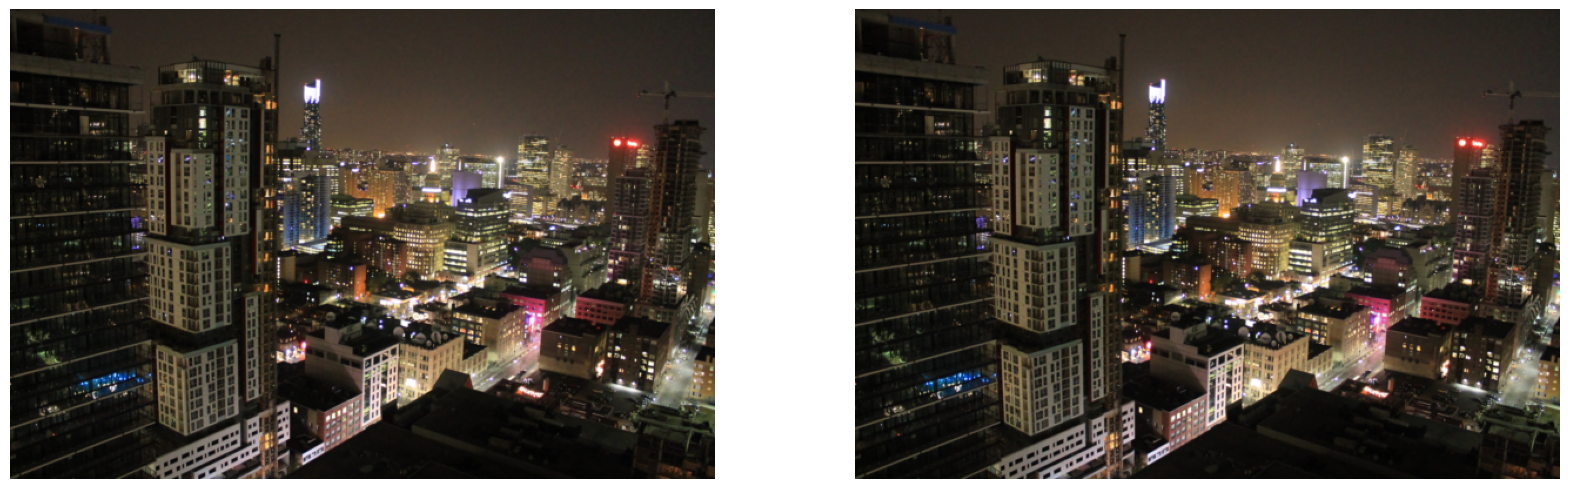

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")

既に説明した通り、必要な層のパラメータを取得する関数

In [ ]:
def get_features(image, model):
  layers = {'0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # Content Extraction
            '28': 'conv5_1'}
  features = {}
  for name, layer in model._modules.items():
    image = layer(image)
    if name in layers:
      features[layers[name]] = image
  return features

コンテンツとスタイルそれぞれの必要な層のパラメータを取得

In [ ]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

グラム行列($\boldsymbol{A} \cdot \boldsymbol{A})$を求める
- 既に説明した通り損失を得るために必要

In [ ]:
def gram_matrix(tensor):
  _, d, h, w = tensor.size()
  tensor = tensor.view(d, h * w)
  gram = torch.mm(tensor, tensor.t())
  return gram

グラム行列の実際の計算

In [ ]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

各層の特徴をどの程度利用するかの比率表
- ここは各自で自由に修正しても面白いであろう

In [ ]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
content_weight = 1  # alpha
style_weight = 1e6  # beta 1e6がデフォルトだが1e4などでも破綻はしない

データを修正するが、オリジナルを取っておきたいのでクローニングする
- 違うメモリに画像データを格納する
- これをそのままNNにかけるのでAutogradをONにする

In [ ]:
target = content.clone().requires_grad_(True).to(device)

各種ハイパーパラメタ
- 特に修正する必要はないと思が、STEPはどの程度画像を触るかに影響するので、各自で調整するとよいであろう
- np.emptyにより、初期化しない乱雑な画像データを生成する
  - ここではホワイトノイズにはこだわっていないが、十分乱雑である

In [ ]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 2100
height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

実際の処理
- 既に説明した通りにロスを計算している
- ロスを自由に設計してもPyTorchは、.backwordで一発逆誤差伝播法の演算が可能であることがわかる
- 上記capture_frameで指定された変換動画を作成するための画像データ取得間隔毎に、画像をimage_arrayに蓄えている

In [ ]:
for ii in range(1, steps+1):
  target_features = get_features(target, vgg) # VGGから特徴量を抜き出す
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2) # 損失関数
  style_loss = 0
  for layer in style_weights: # スタイルの抽出
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)
  total_loss = content_weight * content_loss + style_weight * style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  if  ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis("off")
    plt.show()
  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter = counter + 1

Output hidden; open in https://colab.research.google.com to view.

最終結果の表示

(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

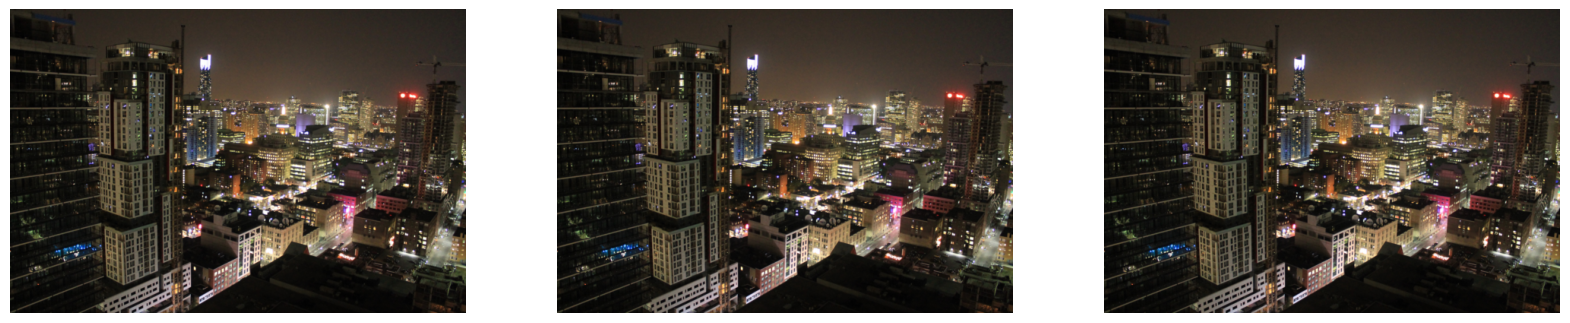

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

途中結果(image_array)を用いて変換動画(output.mp4)を作成

In [ ]:
import cv2
frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))
for i in range(0, 300):
  img = image_array[i]
  img = img*255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)
vid.release()

結果をブラウザからダウンロードさせる
- こんなこともできるよ、ということ
  - Google Colaboratoryで実行しているときのみ、ファイルをダウンロードできるようにしている

In [ ]:
import sys
moduleList = sys.modules
if 'google.colab' in moduleList:
  from google.colab import files
  files.download('output.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

有料サービスの場合、ユニット数が計算時間ではなく、ランタイムを接続している時間で消費されるため、ユニット数消費を減らすために、次の命令でセッションを終了させるとよい

なお、このテキストでは、以下このような配慮は行わないので注意すること

In [ ]:
#from google.colab import runtime
#runtime.unassign()

# 課題7(StyleTransfer)

なんでもよいので、自分の好きな画像とスタイル画像を用いて、変換してみよう！

## レポート条件

レポートにコンテンツ画像、スタイル画像、変換後画像をそれぞれ添付しなさい
  - スタイル画像は上記のままでも問題ありません

# Interoperable Learningしてみよう

CNNは人時代を気付いたが、近年は計算リソースやデータセットを大量に投入できるトップ実例や研究ではそれほど利用されておらず、Vision Transformerに置き換わりつつある

また、Style Transferについても、StyleGANにおけるマスクを用いた手法など、様々な場所で関連する内容を見ることができるであろう

別テキストでVision TransformerやStyleGANについて学ぶことができる